In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## Load Raw Data

In [328]:
# Load the dataset
df = pd.read_csv('labour_force_stats_sri_lanka.csv')

print(df.describe())
print(df.columns)

          YEAR         MONTH        SECTOR      DISTRICT           PSU  \
count  18937.0  18937.000000  18937.000000  18937.000000  18937.000000   
mean    2023.0      6.338913      1.882558     42.767598     64.453345   
std        0.0      3.447620      0.433519     26.081850     53.581280   
min     2023.0      1.000000      1.000000     11.000000      1.000000   
25%     2023.0      3.000000      2.000000     21.000000     25.000000   
50%     2023.0      6.000000      2.000000     41.000000     50.000000   
75%     2023.0      9.000000      2.000000     61.000000     87.000000   
max     2023.0     12.000000      3.000000     92.000000    260.000000   

              HUNIT         HHOLD         SERNO         RSHIP           SEX  \
count  18937.000000  18937.000000  18937.000000  18937.000000  18937.000000   
mean       5.411417      1.004436      2.574959      2.500449      1.528014   
std        2.869758      0.078142      1.492303      1.301186      0.499228   
min        1.0000

# Filter records where AGE > 15, as employees must be at least 15 years old.


In [329]:
# Filter records where AGE >= 15
original_shape = df.shape
df = df[df['AGE'] > 15]
print(f"Filtered dataset shape (AGE > 15): {df.shape}")
print(f"Rows removed: {original_shape[0] - df.shape[0]}")

Filtered dataset shape (AGE > 15): (14894, 128)
Rows removed: 4043


# Choosing columns that are relevant to the analysis

In [330]:
# Select specific columns
selected_columns = [ 'DISTRICT', 'SEX', 'AGE', 'MARITAL', 'EDU', 'SIN', 'ENG', 'TAMIL', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'Q9', 'Q45']
df = df[selected_columns]
print(df.head())

   DISTRICT  SEX  AGE  MARITAL EDU SIN ENG TAMIL  P15  P16  P17  P18  P19  \
0        11    2   34        2   6   1   2     2    1    1    1    1    1   
1        11    1   29        2  13   1   1     2    1    1    1    1    1   
2        11    1   56        2  19   2   2     2    1    1    1    1    1   
3        11    2   44        2   4   2   2     2    1    1    1    1    1   
4        11    1   19        1   5   2   2     2    1    1    2    3    2   

   P20 Q9 Q45  
0    1         
1    1  1   1  
2    1  1   1  
3    1         
4    2         


# Change non-descriptive column names to meaningful ones

In [331]:
rename_map = {
    'P15': 'Visual Impairment',
    'P16': 'Hearing Impairment',
    'P17': 'Mobility Impairment',
    'P18': 'Cognitive Impairment',
    'P19': 'Self-Care Impairment',
    'P20': 'Speech Impairment',
    'Q9': 'Primary Employment',
    'Q45': 'Secondary Employment'
}

df = df.rename(columns=rename_map)
print(df.head())

   DISTRICT  SEX  AGE  MARITAL EDU SIN ENG TAMIL  Visual Impairment  \
0        11    2   34        2   6   1   2     2                  1   
1        11    1   29        2  13   1   1     2                  1   
2        11    1   56        2  19   2   2     2                  1   
3        11    2   44        2   4   2   2     2                  1   
4        11    1   19        1   5   2   2     2                  1   

   Hearing Impairment  Mobility Impairment  Cognitive Impairment  \
0                   1                    1                     1   
1                   1                    1                     1   
2                   1                    1                     1   
3                   1                    1                     1   
4                   1                    2                     3   

   Self-Care Impairment  Speech Impairment Primary Employment  \
0                     1                  1                      
1                     1           

# Transform non-numeric column data into numeric format

In [332]:
# Check data types of all columns
print("Data types of selected columns:")
print("=" * 50)
print(df.dtypes)
print("\n" + "=" * 50)
print("Non-numeric columns (excluded from correlation):")
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print(non_numeric_cols if non_numeric_cols else "None")
print("\n" + "=" * 50)
print("Numeric columns (included in correlation):")
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(numeric_cols)

# Get non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

print("Converting non-numeric columns to numeric:")
print("=" * 50)

# Apply label encoding to non-numeric columns
le_dict = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le
    print(f"{col}: {len(le.classes_)} unique values")

print("\n" + "=" * 50)
print("All columns are now numeric!")
print(f"Data shape: {df.shape}")
print("\nData types after conversion:")
print(df.dtypes)

Data types of selected columns:
DISTRICT                 int64
SEX                      int64
AGE                      int64
MARITAL                  int64
EDU                     object
SIN                     object
ENG                     object
TAMIL                   object
Visual Impairment        int64
Hearing Impairment       int64
Mobility Impairment      int64
Cognitive Impairment     int64
Self-Care Impairment     int64
Speech Impairment        int64
Primary Employment      object
Secondary Employment    object
dtype: object

Non-numeric columns (excluded from correlation):
['EDU', 'SIN', 'ENG', 'TAMIL', 'Primary Employment', 'Secondary Employment']

Numeric columns (included in correlation):
['DISTRICT', 'SEX', 'AGE', 'MARITAL', 'Visual Impairment', 'Hearing Impairment', 'Mobility Impairment', 'Cognitive Impairment', 'Self-Care Impairment', 'Speech Impairment']
Converting non-numeric columns to numeric:
EDU: 19 unique values
SIN: 2 unique values
ENG: 2 unique values
TAMIL: 

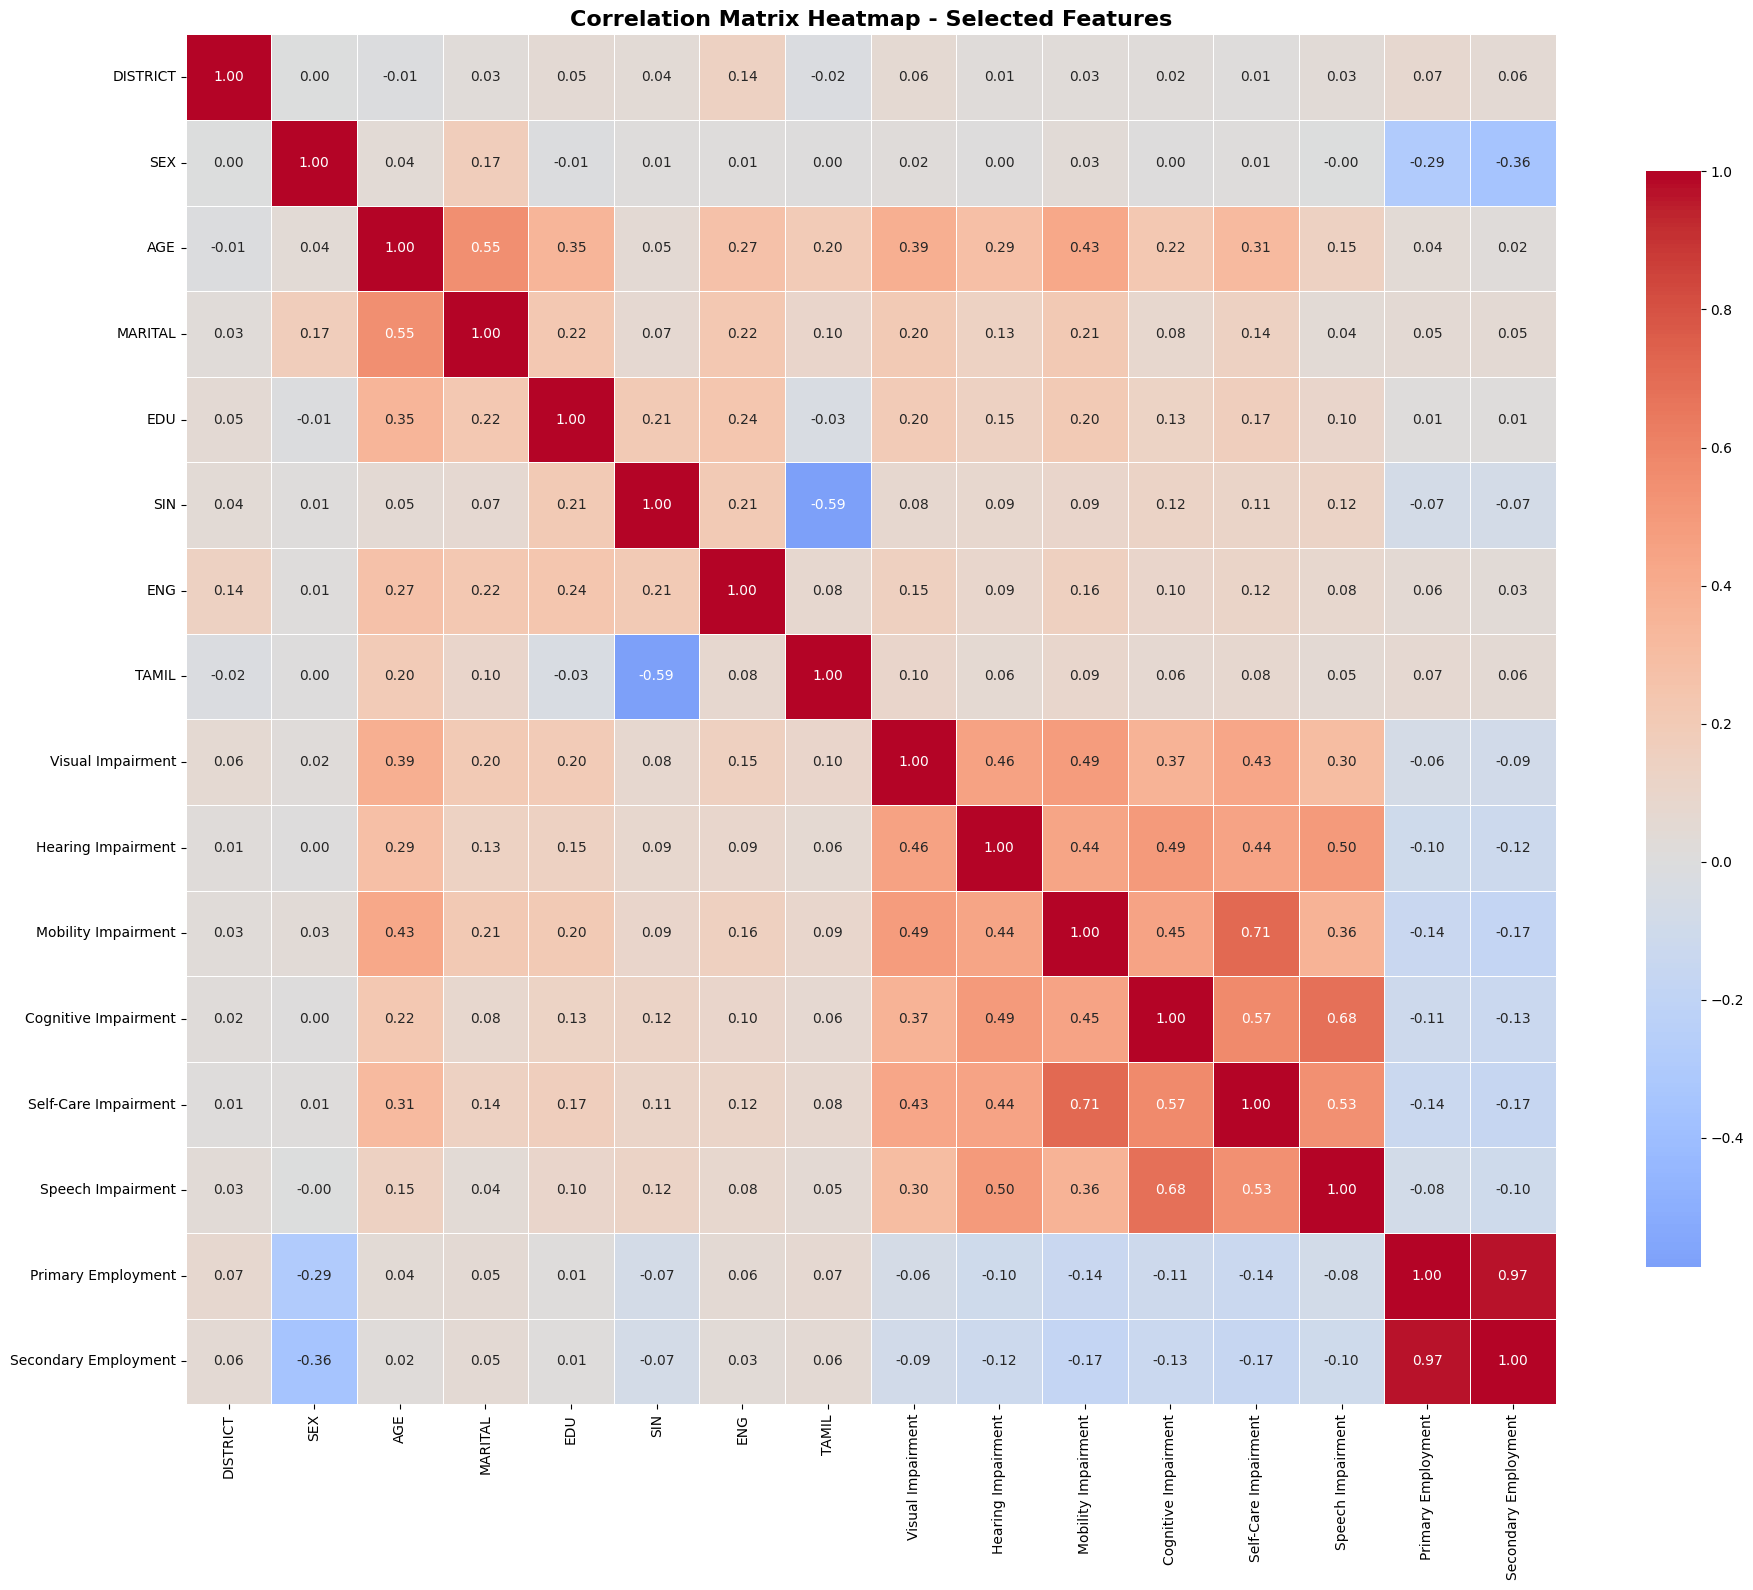

In [333]:
# Calculate correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Create a larger figure for better visibility
plt.figure(figsize=(20, 16))

# Create heatmap
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix Heatmap - Selected Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Combine individual language columns into a single column capturing all language combinations

In [334]:
# Combine SIN, ENG, TAMIL into a single Language Profile column
# This creates meaningful categories representing language combinations

def create_language_profile(row):
    """
    Creates a language profile based on SIN, ENG, TAMIL values
    Returns the specific languages or combination
    """
    languages = []
    if row['SIN'] == 1:
        languages.append('SIN')
    if row['ENG'] == 1:
        languages.append('ENG')
    if row['TAMIL'] == 1:
        languages.append('TAMIL')

    if not languages:
        return 'None'
    elif len(languages) == 1:
        return languages[0]
    else:
        return '+'.join(languages)

# Create the new Language Profile column
df['Languages Spoken Category'] = df.apply(create_language_profile, axis=1)

# Display the results
print("✓ Language Profile column created successfully!")
print(f"\nLanguage Profile value counts:")
print(df['Languages Spoken Category'].value_counts().sort_index())
print(f"\nLanguage Profile distribution (%):")
print((df['Languages Spoken Category'].value_counts() / len(df) * 100).round(2))

# Show some examples
print(f"\nSample of combined data:")
print(df[['SIN', 'ENG', 'TAMIL', 'Languages Spoken Category']].head(20))

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fix: Use df instead of df to access 'Languages Spoken Category'
df['Languages Spoken'] = label_encoder.fit_transform(df['Languages Spoken Category'])
print(f"\nEncoded Language Profile:")
print(df[['Languages Spoken Category', 'Languages Spoken']].drop_duplicates().sort_values('Languages Spoken'))

# Optional: Drop the original SIN, ENG, TAMIL columns if you want to simplify
df = df.drop(columns=['SIN', 'ENG', 'TAMIL'])

print(f"\n✓ Final dataset shape: {df.shape}")
print(f"✓ Original three language columns replaced with: Languages Spoken Category (categorical) and Languages Spoken (numeric)")
print(f"\nFinal columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

✓ Language Profile column created successfully!

Language Profile value counts:
Languages Spoken Category
ENG               384
ENG+TAMIL        6640
None              928
SIN               530
SIN+ENG          2431
SIN+ENG+TAMIL    1161
SIN+TAMIL          20
TAMIL            2800
Name: count, dtype: int64

Language Profile distribution (%):
Languages Spoken Category
ENG+TAMIL        44.58
TAMIL            18.80
SIN+ENG          16.32
SIN+ENG+TAMIL     7.80
None              6.23
SIN               3.56
ENG               2.58
SIN+TAMIL         0.13
Name: count, dtype: float64

Sample of combined data:
    SIN  ENG  TAMIL Languages Spoken Category
0     0    1      1                 ENG+TAMIL
1     0    0      1                     TAMIL
2     1    1      1             SIN+ENG+TAMIL
3     1    1      1             SIN+ENG+TAMIL
4     1    1      1             SIN+ENG+TAMIL
5     0    1      1                 ENG+TAMIL
7     1    1      1             SIN+ENG+TAMIL
8     0    1      1     

# Consolidate all impairment fields into a single Disability indicator column

In [335]:
# First, rename the existing disability columns to the new names provided by the user
disability_columns = [
    'Visual Impairment', 'Hearing Impairment', 'Mobility Impairment',
    'Cognitive Impairment', 'Self-Care Impairment', 'Speech Impairment'
]




# 1. Count number of disabilities (count of non-1 values)
# Value 1 = No difficulties, values 2-4 = Has disability
df['Disability_Count'] = (df[disability_columns] > 1).sum(axis=1)

# 2. Overall Disability Severity Score (sum of all values, range 6-24)
df['Disability_Severity_Score'] = df[disability_columns].sum(axis=1)

# 3. Maximum disability severity (worst disability level)
df['Max_Disability_Severity'] = df[disability_columns].max(axis=1)

# 4. Create meaningful disability category
def categorize_disability(severity_score):
    """
    Categorizes based on overall severity score (sum of all 6 disability columns)
    Score range: 6-24 (6 columns × 1-4 values)
    """
    if severity_score == 6:
        return 'No Disabilities'
    elif severity_score <= 9:
        return 'Mild Disabilities'
    elif severity_score <= 15:
        return 'Moderate Disabilities'
    else:
        return 'Severe Disabilities'

df['Disability Category'] = df['Disability_Severity_Score'].apply(categorize_disability)


df['Disability'] = label_encoder.fit_transform(df['Disability Category'])

# Drop original disability columns to simplify dataset
df = df.drop(columns=disability_columns)
df = df.drop(columns=['Disability_Count', 'Disability_Severity_Score', 'Max_Disability_Severity'])

print("Disability features engineered and original columns dropped.")
print("Updated df head:")
print(df.head())
print("\nNew columns added:")
print([col for col in df.columns if 'Disability' in col])

Disability features engineered and original columns dropped.
Updated df head:
   DISTRICT  SEX  AGE  MARITAL  EDU  Primary Employment  Secondary Employment  \
0        11    2   34        2   15                   0                     0   
1        11    1   29        2    5                   1                     1   
2        11    1   56        2   10                   1                     1   
3        11    2   44        2   13                   0                     0   
4        11    1   19        1   14                   0                     0   

  Languages Spoken Category  Languages Spoken    Disability Category  \
0                 ENG+TAMIL                 1        No Disabilities   
1                     TAMIL                 7        No Disabilities   
2             SIN+ENG+TAMIL                 5        No Disabilities   
3             SIN+ENG+TAMIL                 5        No Disabilities   
4             SIN+ENG+TAMIL                 5  Moderate Disabilities   

  

# Merge Primary and Secondary Employment into one Employment column

In [336]:
# Analyze 'Primary Employment' and 'Secondary Employment' columns from df
print("Distribution of 'Primary Employment' column:")
display(df['Primary Employment'].value_counts())

print("\nDistribution of 'Secondary Employment' column:")
display(df['Secondary Employment'].value_counts())

# Compare if the columns are identical
if df['Primary Employment'].equals(df['Secondary Employment']):
    df = df.drop(columns=['Secondary Employment'])
else:

    # Create 'Employment Status Categorical'
    def get_employment_status(row):
        if row['Primary Employment'] == 0 and row['Secondary Employment'] == 0:
            return 'Unemployed'
        else:
            return 'Employed'

    df['Employment Status Category'] = df.apply(get_employment_status, axis=1)

    employment_status_mapping = {
        'Unemployed': 0,
        'Employed': 1
    }

    df['Employment Status'] = df['Employment Status Category'].map(employment_status_mapping)

    # Drop original columns after combining
    df = df.drop(columns=['Primary Employment', 'Secondary Employment'])

    print("\nDistribution of 'Employment Status Categorical':")
    display(df['Employment Status Category'].value_counts())

print("\nFirst 5 rows of the DataFrame after combining employment columns:")
display(df.head())

Distribution of 'Primary Employment' column:


Primary Employment
0    7842
1    4182
3    2277
4     396
2     197
Name: count, dtype: int64


Distribution of 'Secondary Employment' column:


Secondary Employment
0    7842
1    4182
2    2870
Name: count, dtype: int64


Distribution of 'Employment Status Categorical':


Employment Status Category
Unemployed    7842
Employed      7052
Name: count, dtype: int64


First 5 rows of the DataFrame after combining employment columns:


DISTRICT  SEX  AGE  MARITAL  EDU Languages Spoken Category  \
0        11    2   34        2   15                 ENG+TAMIL   
1        11    1   29        2    5                     TAMIL   
2        11    1   56        2   10             SIN+ENG+TAMIL   
3        11    2   44        2   13             SIN+ENG+TAMIL   
4        11    1   19        1   14             SIN+ENG+TAMIL   

   Languages Spoken    Disability Category  Disability  \
0                 1        No Disabilities           2   
1                 7        No Disabilities           2   
2                 5        No Disabilities           2   
3                 5        No Disabilities           2   
4                 5  Moderate Disabilities           1   

  Employment Status Category  Employment Status  
0                 Unemployed                  0  
1                   Employed                  1  
2                   Employed                  1  
3                 Unemployed                  0  
4                 Unemployed                  0

In [337]:
print(df.head())

   DISTRICT  SEX  AGE  MARITAL  EDU Languages Spoken Category  \
0        11    2   34        2   15                 ENG+TAMIL   
1        11    1   29        2    5                     TAMIL   
2        11    1   56        2   10             SIN+ENG+TAMIL   
3        11    2   44        2   13             SIN+ENG+TAMIL   
4        11    1   19        1   14             SIN+ENG+TAMIL   

   Languages Spoken    Disability Category  Disability  \
0                 1        No Disabilities           2   
1                 7        No Disabilities           2   
2                 5        No Disabilities           2   
3                 5        No Disabilities           2   
4                 5  Moderate Disabilities           1   

  Employment Status Category  Employment Status  
0                 Unemployed                  0  
1                   Employed                  1  
2                   Employed                  1  
3                 Unemployed                  0  
4         

## Data Model Training

In [338]:
# Identify missing values for each column
missing_values = df.isnull().sum()

# Display columns with missing values and their counts
print("Number of missing values per column:")
display(missing_values[missing_values > 0])

# If no columns have missing values, inform the user
if missing_values.sum() == 0:
    print("No missing values found in the DataFrame.")

Number of missing values per column:


Series([], dtype: int64)

No missing values found in the DataFrame.


In [339]:
target_column = 'Employment Status'

# List of object columns to drop from features
object_columns_to_drop = [
    'Languages Spoken Category',
    'Disability Category',
    'Employment Status Category'
]

# Drop target column and the identified object columns from X
X = df.drop(columns=[target_column] + object_columns_to_drop)
y = df[target_column]

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

print("\nFirst few rows of X:")
display(X.head())

print("\nFirst few rows of y:")
display(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Shape of X (features): (14894, 7)
Shape of y (target): (14894,)

First few rows of X:


DISTRICT  SEX  AGE  MARITAL  EDU  Languages Spoken  Disability
0        11    2   34        2   15                 1           2
1        11    1   29        2    5                 7           2
2        11    1   56        2   10                 5           2
3        11    2   44        2   13                 5           2
4        11    1   19        1   14                 5           1


First few rows of y:


0    0
1    1
2    1
3    0
4    0
Name: Employment Status, dtype: int64

# Use LightGBM Classifier

In [340]:
# 1. Define the model with some basic constraints to prevent overfitting
lgbm_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    importance_type='gain' # Better for interpreting SHAP values
)

# 2. Define a parameter grid
# We target the 'Recall' issue by adjusting scale_pos_weight if the classes are imbalanced
param_grid = {
    'n_estimators': [100, 500],           # More trees can capture more complexity
    'learning_rate': [0.01, 0.05, 0.1],   # Smaller steps often lead to better generalization
    'num_leaves': [31, 63],               # Increases the complexity of the trees
    'max_depth': [-1, 10, 20],            # Limits depth to prevent overfitting
    'scale_pos_weight': [1, 1.5]          # Helps improve Recall for the minority class
}

# 3. Initialize Grid Search with Cross-Validation
# Scoring on 'f1' or 'roc_auc' is usually better than 'accuracy' for performance
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1
)

print("Starting Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

# 4. Use the best model
best_lgbm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4533, number of negative: 4999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 9532, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475556 -> initscore=-0.097854
[LightGBM] [Info] Start training from score -0.097854
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4533, number of negative: 4999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force


LightGBM Model Performance:
Accuracy:  0.7620
Precision: 0.7267
Recall:    0.7828
F1-Score:  0.7537


/tmp/ipython-input-1864569324.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='viridis')


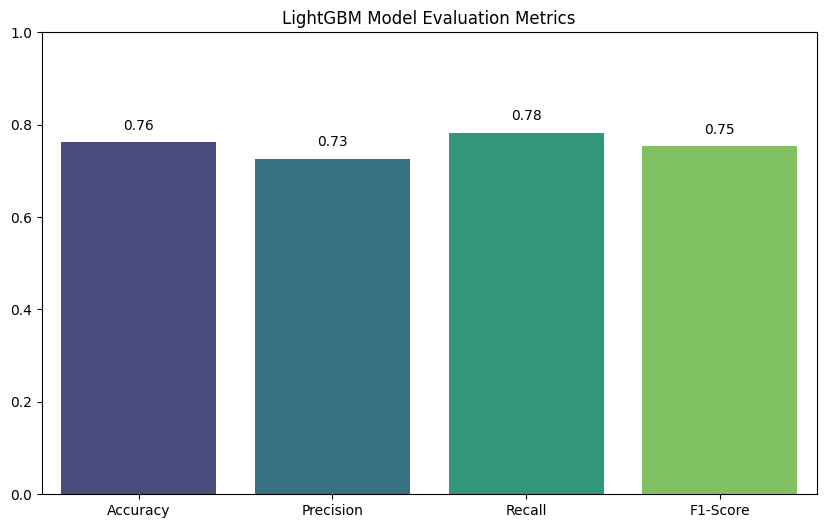


Confusion Matrix:
[[1185  408]
 [ 301 1085]]


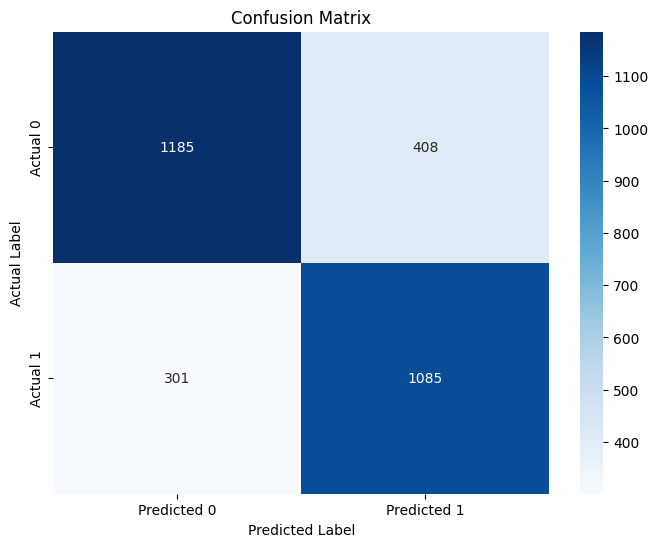

ROC AUC:   0.8597


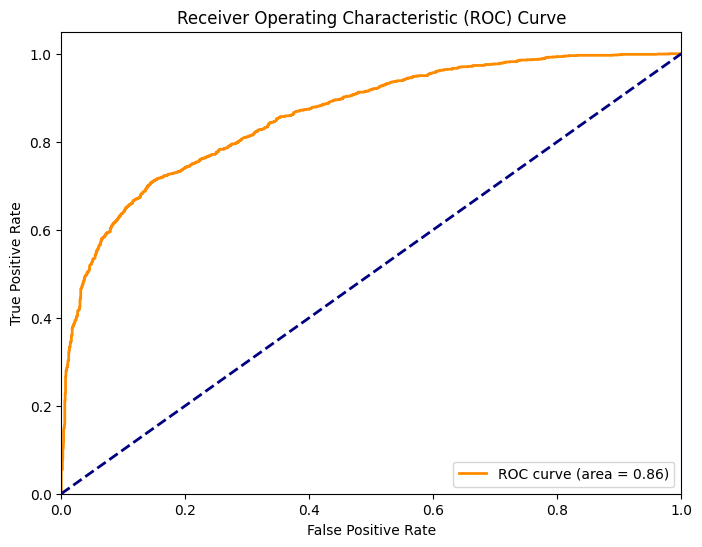

In [341]:
lgbm_model = best_lgbm
# Make predictions
y_pred = best_lgbm.predict(X_test)
y_pred_proba = best_lgbm.predict_proba(X_test)[:, 1] # Probability of the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)



print(f"\nLightGBM Model Performance:")

# Plotting the evaluation metrics

# 1. Bar plot for Accuracy, Precision, Recall, F1-Score
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=scores, palette='viridis')
plt.title('LightGBM Model Evaluation Metrics')
plt.ylim(0, 1)
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')
plt.show()

# 2. Confusion Matrix Heatmap
print(f"\nConfusion Matrix:\n{conf_matrix}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. ROC Curve
print(f"ROC AUC:   {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#Perform SHAP analysis on the trained `lgbm_model` to interpret individual predictions and feature contributions, calculate SHAP values, and generate summary plots and force plots.

100%|===================| 2967/2979 [01:06<00:00]       

Generating SHAP Summary Plot (Bar)...


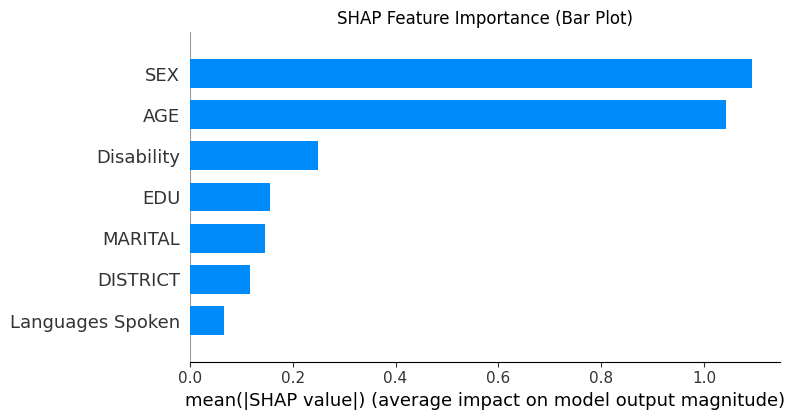


Generating SHAP Summary Plot (Beeswarm)...


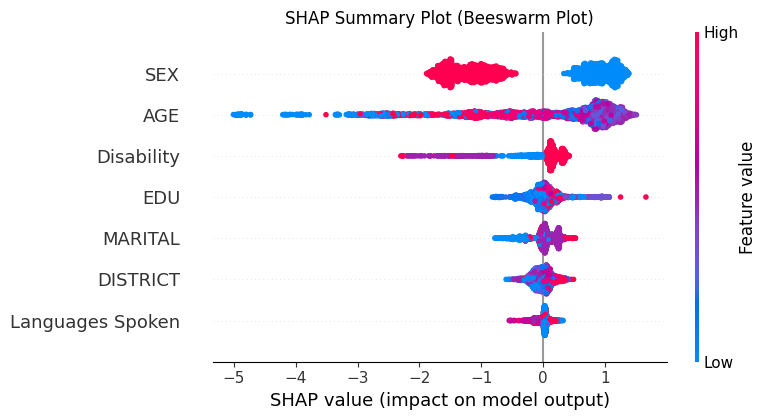


Generating SHAP Force Plot for instance 2...


SHAP analysis complete: Summary plots and Force plot generated.


In [342]:
# 2. Initialize a TreeExplainer object
# Use the trained LightGBM model to create a SHAP explainer
explainer = shap.TreeExplainer(lgbm_model, X, model_output='raw', feature_perturbation='interventional')

# 3. Calculate the SHAP values for the X_test dataset
# Based on the kernel state and error, explainer.shap_values(X_test)
# appears to be returning a single 2D numpy array (n_samples, n_features).
# If it were a list of arrays for binary classification, we would use shap_values[1].
# However, since the error indicates shap_values[1] is a vector, it means
# `shap_values` itself is already the (n_samples, n_features) matrix, and [1] is
# incorrectly trying to select the second row, which is a 1D vector.
shap_values = explainer.shap_values(X_test)

# For force plot, explainer.expected_value will be a scalar for this case.
expected_value = explainer.expected_value

# 4. Generate a SHAP summary plot
print("Generating SHAP Summary Plot (Bar)...")
plt.figure(figsize=(10, 6))
# Pass the full 2D shap_values array directly for the summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.show()

print("\nGenerating SHAP Summary Plot (Beeswarm)...")
plt.figure(figsize=(10, 6))
# Pass the full 2D shap_values array directly for the summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot (Beeswarm Plot)')
plt.tight_layout()
plt.show()

# 5. Generate a SHAP force plot for a specific instance
# Select the first instance from X_test for the force plot
instance_to_explain_idx = 2
instance_to_explain = X.iloc[instance_to_explain_idx,:]

print(f"\nGenerating SHAP Force Plot for instance {instance_to_explain_idx}...")
# For a single array output, explainer.expected_value is a scalar,
# and shap_values[instance_to_explain_idx] gives the SHAP values for that instance.
shap.initjs()
shap.force_plot(expected_value, shap_values[instance_to_explain_idx,:], instance_to_explain)

print("SHAP analysis complete: Summary plots and Force plot generated.")

**Reasoning**:
To further interpret the model's behavior, generating a SHAP dependence plot will visualize how a single feature (the most important one identified) impacts the model's output, potentially revealing interactions with other features. This is a logical next step after generating summary and force plots.



(For context: Most important feature based on SHAP values is 'SEX')

Generating SHAP Dependence Plot for 'AGE', colored by 'SEX'...


<Figure size 1000x600 with 0 Axes>

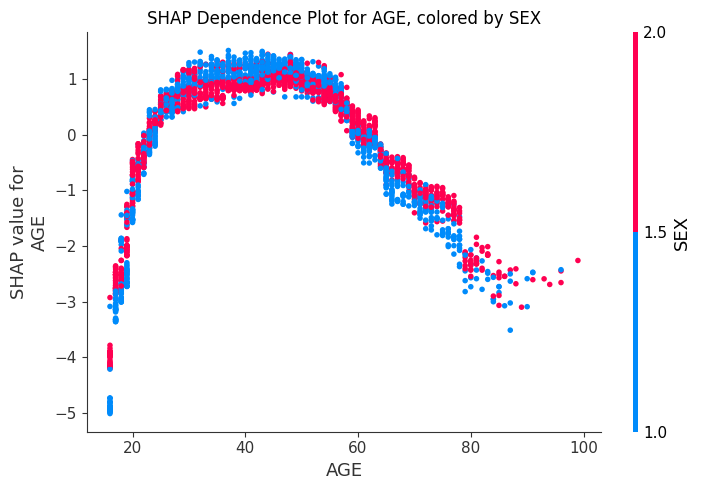


SHAP Dependence Plot for 'AGE' colored by 'SEX' generated successfully.


In [343]:
# Calculate mean absolute SHAP value for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Get the name of the most important feature (for context, even if we override for 'AGE')
most_important_feature_idx = np.argmax(mean_abs_shap_values)
most_important_feature_context = X_test.columns[most_important_feature_idx]

print(f"(For context: Most important feature based on SHAP values is '{most_important_feature_context}')")

# Generate a SHAP dependence plot explicitly for 'AGE', colored by 'SEX'
print(f"\nGenerating SHAP Dependence Plot for 'AGE', colored by 'SEX'...")
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    ind='AGE', # Explicitly set to 'AGE' as requested by the user
    shap_values=shap_values,
    features=X_test,
    interaction_index='SEX', # Color the dots according to 'SEX'
    show=False
)
plt.title('SHAP Dependence Plot for AGE, colored by SEX')
plt.tight_layout()
plt.show()

print("\nSHAP Dependence Plot for 'AGE' colored by 'SEX' generated successfully.")

## LIME Analysis

Implement LIME (Local Interpretable Model-agnostic Explanations) to understand the predictions of the LightGBM model locally. This will involve selecting a few instances and generating local explanations, including visualizations of feature contributions for those specific predictions.


In [344]:
#import sys
#!{sys.executable} -m pip install lime

import lime
import lime.lime_tabular
from lightgbm import LGBMClassifier

In [345]:
# Define a wrapper function for predict_proba that accepts a numpy array
# and converts it to a DataFrame with correct feature names before prediction
def predict_proba_wrapper(data):
    # `data` will be a numpy array provided by LIME
    data_df = pd.DataFrame(data, columns=X_train.columns)
    return lgbm_model.predict_proba(data_df)

# 1. Instantiate LimeTabularExplainer
# X_train is a pandas DataFrame, so we can use its values and column names
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Not Employed', 'Employed'], # Assuming 0: Not Employed, 1: Employed
    mode='classification'
)
print("LimeTabularExplainer instantiated.")

# 2. Select a few instances from X_test to explain
# Choose 3 instances: one from each class, and one more for diversity
# Get indices of instances with actual class 0 and class 1 from y_test
idx_class_0 = y_test[y_test == 0].index[0]
idx_class_1 = y_test[y_test == 1].index[0]

# Get a third arbitrary index, ensuring it's different
idx_arbitrary = y_test.index[5] # Selecting the 5th element from y_test

# Convert actual test indices to indices within X_test/y_test after train_test_split
instance_indices = [
    X_test.index.get_loc(idx_class_0),
    X_test.index.get_loc(idx_class_1),
    X_test.index.get_loc(idx_arbitrary)
]

print(f"\nSelected instances for LIME explanation (indices in X_test): {instance_indices}")

# 3. For each selected instance, generate a LIME explanation
# 4. Visualize each local explanation
for i, idx_in_X_test in enumerate(instance_indices):
    instance_array = X_test.iloc[idx_in_X_test].values
    # Convert the instance array back to a DataFrame for prediction to avoid warnings
    # when directly predicting with lgbm_model outside of LIME's call
    instance_df = pd.DataFrame(instance_array.reshape(1, -1), columns=X_test.columns)

    true_label = y_test.iloc[idx_in_X_test]
    # Use the lgbm_model directly for prediction here, passing the DataFrame
    predicted_proba = lgbm_model.predict_proba(instance_df)[0]
    predicted_label = lgbm_model.predict(instance_df)[0]

    print(f"\n--- Explaining Instance {i+1} (Original index: {X_test.index[idx_in_X_test]}) ---")
    print(f"Actual Label: {'Employed' if true_label == 1 else 'Not Employed'}")
    print(f"Predicted Label: {'Employed' if predicted_label == 1 else 'Not Employed'}")
    print(f"Predicted Probabilities: {predicted_proba}")

    # Generate explanation for the instance
    # Pass the wrapper function to LIME's explain_instance
    explanation = explainer.explain_instance(
        data_row=instance_array, # LIME explainer itself expects a numpy array
        predict_fn=predict_proba_wrapper, # Use the wrapper here
        num_features=X_test.shape[1] # Show all features
    )

    # Visualize the explanation
    print(f"Generating LIME explanation plot for instance {i+1}...")
    explanation.show_in_notebook(show_table=True, show_all=False)

    # Added step: Print top feature contributions numerically
    print(f"Top feature contributions for instance {i+1}:")
    for feature, weight in explanation.as_list():
        print(f"  - {feature}: {weight:.4f}")

print("\nLIME analysis complete: Explanations generated and visualized for selected instances.")

LimeTabularExplainer instantiated.

Selected instances for LIME explanation (indices in X_test): [1, 0, 5]

--- Explaining Instance 1 (Original index: 17157) ---
Actual Label: Not Employed
Predicted Label: Employed
Predicted Probabilities: [0.45719332 0.54280668]
Generating LIME explanation plot for instance 1...


Top feature contributions for instance 1:
  - 1.00 < SEX <= 2.00: -0.2292
  - 45.00 < AGE <= 60.00: 0.1307
  - Disability <= 2.00: 0.1269
  - DISTRICT > 61.00: 0.0407
  - MARITAL <= 2.00: -0.0325
  - Languages Spoken <= 1.00: 0.0270
  - EDU > 11.00: 0.0193

--- Explaining Instance 2 (Original index: 4357) ---
Actual Label: Employed
Predicted Label: Not Employed
Predicted Probabilities: [0.50290523 0.49709477]
Generating LIME explanation plot for instance 2...


Top feature contributions for instance 2:
  - 1.00 < SEX <= 2.00: -0.2336
  - 30.00 < AGE <= 45.00: 0.1495
  - Disability <= 2.00: 0.0834
  - DISTRICT <= 21.00: -0.0249
  - 2.00 < EDU <= 5.00: -0.0230
  - Languages Spoken <= 1.00: 0.0157
  - MARITAL <= 2.00: -0.0152

--- Explaining Instance 3 (Original index: 18107) ---
Actual Label: Employed
Predicted Label: Employed
Predicted Probabilities: [0.49821381 0.50178619]
Generating LIME explanation plot for instance 3...


Top feature contributions for instance 3:
  - 1.00 < SEX <= 2.00: -0.2354
  - Disability <= 2.00: 0.1754
  - AGE <= 30.00: -0.0545
  - MARITAL <= 2.00: -0.0369
  - 2.00 < EDU <= 5.00: -0.0301
  - DISTRICT > 61.00: 0.0268
  - Languages Spoken <= 1.00: 0.0198

LIME analysis complete: Explanations generated and visualized for selected instances.


## Feature Importance Analysis

Calculate and visualize the overall feature importance for the LightGBM model. This typically involves using the model's built-in feature importance attribute or permutation importance, and then presenting the results as a bar chart.


Calculating and visualizing feature importance...

Feature Importance (sorted descending):
            Feature     Importance
2               AGE  196351.705470
1               SEX  117209.632721
4               EDU   31487.380418
6        Disability   21846.504751
0          DISTRICT   19832.209824
3           MARITAL   15861.337275
5  Languages Spoken    9499.260793


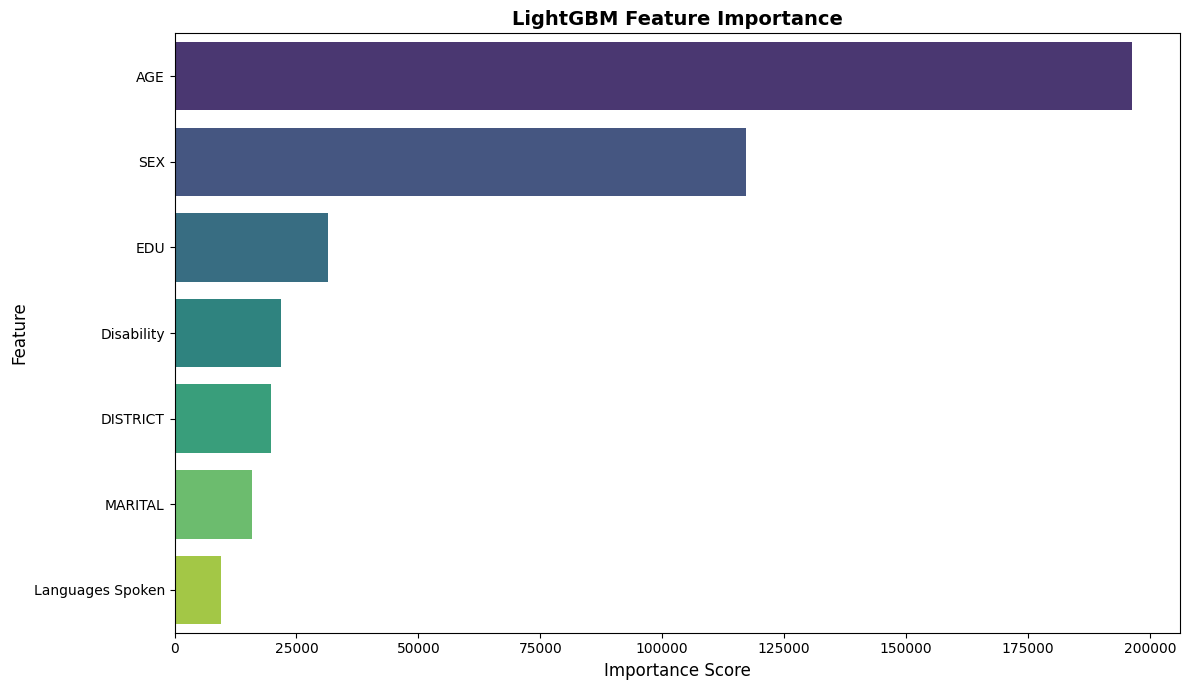


Feature importance analysis complete.


In [346]:
print("Calculating and visualizing feature importance...")

# 1. Retrieve the feature importance from the trained lgbm_model
feature_importance = lgbm_model.feature_importances_

# 2. Create a Pandas DataFrame to store the feature names and their corresponding importance scores
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 3. Sort this DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance (sorted descending):")
print(importance_df)

# 4. Create a bar chart using seaborn.barplot to visualize the feature importance
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', legend=False)

# 5. Add appropriate labels for the x and y axes, and a title for the plot.
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()

# 6. Display the plot.
plt.show()

print("\nFeature importance analysis complete.")

## Partial Dependence Plots (PDP)

Generate Partial Dependence Plots (PDPs) to show the marginal effect of one or two features on the predicted outcome of the LightGBM model. This will involve selecting key features and plotting their relationship with the model's output.


In [347]:
from sklearn.inspection import PartialDependenceDisplay

Generating Partial Dependence Plots...


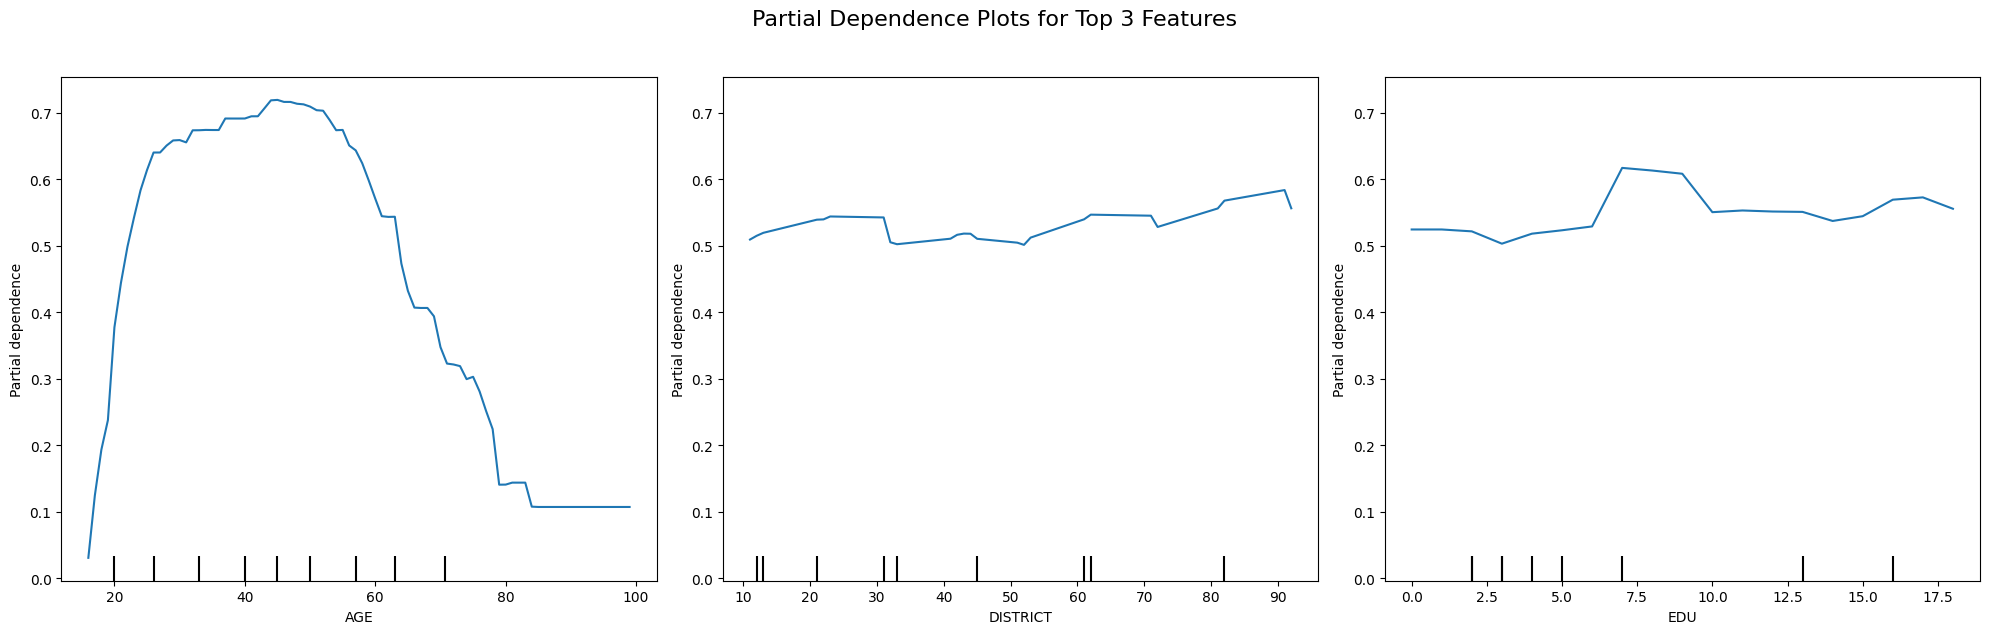

Partial Dependence Plots generated successfully.


In [348]:
# 2. Define a list of the top 3 most important features for PDPs
# These were identified from the previous feature importance analysis
features_for_pdp = ['AGE', 'DISTRICT', 'EDU']

# 3. Create a figure and axes for the plots
# Since there are 3 features, a 1x3 subplot layout is suitable
fig, ax = plt.subplots(ncols=len(features_for_pdp), figsize=(20, 6))

# 4. Use PartialDependenceDisplay.from_estimator to generate and plot the PDPs
print("Generating Partial Dependence Plots...")
PartialDependenceDisplay.from_estimator(
    estimator=lgbm_model,
    X=X_test,
    features=features_for_pdp,
    kind='average',
    ax=ax,
    feature_names=X_test.columns.tolist() # Provide feature names explicitly
)

# 5. Add a title to the overall plot and display it.
fig.suptitle('Partial Dependence Plots for Top 3 Features', fontsize=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 1.02]) # Adjust layout to prevent title overlap
plt.show()
print("Partial Dependence Plots generated successfully.")